In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in notebook, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT


This notebook is a first attempt to read in track information and use it to predict the the full target histrograms.

It will read in the TracksToDKE__Ellipsoids_DDPlus model to predict the KDE, and then feed it into a SimpleCNN model to predict the target histograms.  Initially, it will use previously trained weights.


Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Sun Jan 10 00:01:32 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 450.36.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  On   | 00000000:18:00.0 Off |                  N/A |
| 29%   35C    P8    38W / 250W |      1MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  On   | 00000000:3B:00.0 Off |                  N/A |
| 29%   

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd

# Python 3 standard library
from pathlib import Path

from model.efficiency import pv_locations, efficiency

##from torchsummary import summary

### Set up local parameters

In [4]:
n_epochs = 100

# Name is the output file name


##  200719  mds
##folder = '20December_Tracks_to_KDE_TestTrainedModel'
##folder = '22December_testing_DDplus_loss_Bb_iter2_floatAll_100epochs_3em6'
folder = '09Jan2021_Tracks_to_Hists_Iteration_5B_100epochs_lr_1em7_2p5_kde2hists_allFloat'
name = folder

# Make an output folder named "name" (change if you want)

## Special instructions for those working on goofy at UC
## Please be very careful to make sure that your folder
## does not live in a subdirectory of your home directory
## this disk has very little capacity. Instead, use 
## a subdirectory in /share/lazy with a symbolic link to
## it in this (the notebooks) subdirectory
folder = 'ML/' + folder
output = Path(folder)


# Size of batches
batch_size = 16
# How fast to learn
learning_rate = 1e-7

Make the output directory if it does not exist:

In [5]:
output.mkdir(exist_ok=True)

## Get the helper functions

Add the directory with the model
definitions to the path so we can import from it:

> When you type `import X`,
Python searches `sys.path` for a python
file named `X.py` to import. So we need to add the model directory to the path.

In [6]:
# From model/collectdata.py
##from model.collectdata_kde_Ellipsoids import collect_t2kde_data
from model.collectdata_t2hists import collect_t2hists_data
from model.collectdata_mdsA  import collect_truth

# From model/loss.py
##from loss import Loss
##from model.kde_loss_D import Loss
## from model.kde_loss_B import Loss  ## Tracks_to_KDE loss, not for target hists

##  "standard" ratios loss for hists training
from model.alt_loss_A import Loss  ## loss used to train RunModel_Demo_28November2020-SimpleCNNLayer_Ca-Restart_5


##from model.models_kde import TracksToKDE_Ellipsoids_DirtyDozen as Model
from model.models_kde import TracksToKDE_Ellipsoids_DDplus as t2kde_model
##from model.models_mds_G import SimpleCNN5Layer_Ca as kde2hists_model
from model.models_mds_28Dec20 import SimpleCNN5Layer_Ca as kde2hists_model  ## copy of models_mds_01June20 for debugging
from model.models_t2hists import TracksToHists_A as t2hists_model


##from model.training_kde import trainNet, select_gpu, Results
## training_t2hists_A.py increases "difference" for accepting found
## peaks as matched from 5 bins to 7.5 bins (compmared to original training.py)
from model.training_t2hists_A import trainNet, select_gpu, Results
from model.plots import dual_train_plots, replace_in_ax

In [7]:
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [8]:
device = select_gpu(0)
##device = "cpu"

1 available GPUs (initially using device 0):
  0 GeForce RTX 2080 Ti


## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

In [9]:
## 210109 let's use some of Will's toy MC for training rather than the 20K sample I've been using

##train_loader = collect_t2hists_data('dataAA/20K_POCA_kernel_evts_200926.h5',
train_loader = collect_t2hists_data('/share/lazy/will/data/June30_2020_80k_1.h5',    
                             batch_size=batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## not the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
##                           device=device,
##                             slice = slice(0,18000)
                           )



                            
# Validation dataset. You can slice to reduce the size.
## mds no separate validation set yet,

## 210109 and use everything in this 20K file for validation
val_loader = collect_t2hists_data('dataAA/20K_POCA_kernel_evts_200926.h5',
                            batch_size=batch_size,
                            device=device,
##                           slice = slice(18000,None)
                           )

PV = collect_truth('dataAA/20K_POCA_kernel_evts_200926.h5', pvs=True)
print('PV.n.shape =    ',  PV.n.shape)
print('PV.n[0].shape = ', *PV.n[0].shape)
print('PV.x[0] =       ', *PV.x[0])
print('PV.y[0] =       ', *PV.y[0])
print('PV.z[0] =       ', *PV.z[0])
print('PV.n[0] =       ', *PV.n[0])
print('PV.cat[0] =     ', *PV.cat[0])

SV = collect_truth('dataAA/20K_POCA_kernel_evts_200926.h5', pvs=False)
print('SV.n.shape =    ', SV.n.shape)
print('SV.n[0].shape = ', *SV.n[0].shape)
print('SV.x[0] =       ', *SV.x[0])
print('SV.y[0] =       ', *SV.y[0])
print('SV.z[0] =       ', *SV.z[0])
print('SV.n[0] =       ', *SV.n[0])
print('SV.cat[0] =     ', *SV.cat[0])


Loading data...
pocaMx.shape =  (80000,)
nEvts =  80000
len(pocaMx[0]) =  199
len(pocaMx[1]) =  25
len(pocaMx[2]) =  369
len(pocaMx[3]) =  143
len(pocaMx[4]) =  160
have entered six_ellipsoid_parameters
  
 
  nEvts =  80000
 iEvt, nTrks =  0 199
 iEvt, nTrks =  1 25
 iEvt, nTrks =  2 369
 iEvt, nTrks =  3 143
 iEvt, nTrks =  4 160
 iEvt, nTrks =  5 260
 iEvt, nTrks =  6 237
 iEvt, nTrks =  7 327
 iEvt, nTrks =  8 178
 iEvt, nTrks =  9 106
len(X) =  80000
len(Xlist) =  1
Loaded /share/lazy/will/data/June30_2020_80k_1.h5 in 105.3 s
outer loop X.shape =  (80000, 9, 600)
Constructing 80000 event dataset took 0.3323 s
x_t.shape =  torch.Size([80000, 9, 600])
x_t.shape[0] =  80000
x_t.shape[1] =  9
x_t.shape =  torch.Size([80000, 9, 600])
Loading data...
pocaMx.shape =  (20000,)
nEvts =  20000
len(pocaMx[0]) =  211
len(pocaMx[1]) =  21
len(pocaMx[2]) =  20
len(pocaMx[3]) =  198
len(pocaMx[4]) =  233
have entered six_ellipsoid_parameters
  
 
  nEvts =  20000
 iEvt, nTrks =  0 211
 iEvt, nTr

# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [10]:
nOut1 = 50
nOut2 = 50
nOut3 = 50
nOut4 = 50
nOut5 = 50
nOut6 = 50
nOut7 = 50
nOut8 = 50
nOut9 = 50
nOut10 = 50
nOut11 = 50
latentChannels = 4
model_t2kde = t2kde_model(nOut1,nOut2,nOut3,nOut4,nOut5,nOut6,nOut7,nOut8,nOut9,nOut10,nOut11,latentChannels)
model_kde2hists = kde2hists_model()
model_t2hists = t2hists_model(nOut1,nOut2,nOut3,nOut4,nOut5,nOut6,nOut7,nOut8,nOut9,nOut10,nOut11,latentChannels)

##summary(model, input_size=(4, 4000))
##print(model.parameters)

## add the following code to allow the user to freeze the some of the weights corresponding 
## to those taken from an earlier model trained with the original target histograms
## presumably -- this leaves either the perturbative filter "fixed" and lets the 
## learning focus on the non-perturbative features, so get started faster, or vice versa
ct = 0
for child in model_t2hists.children():
  print('ct, child = ',ct, "  ", child)
  if (ct < 0) :
    print("     About to set param.requires_grad=False for ct = ", ct, "params")
    for param in child.parameters():
        param.requires_grad = False 
  ct += 1

loss = Loss(epsilon=1e-5,coefficient=2.5)
optimizer = torch.optim.Adam(model_t2hists.parameters(), lr=learning_rate)

ct, child =  0    Linear(in_features=9, out_features=50, bias=True)
ct, child =  1    Linear(in_features=50, out_features=50, bias=True)
ct, child =  2    Linear(in_features=50, out_features=50, bias=True)
ct, child =  3    Linear(in_features=50, out_features=50, bias=True)
ct, child =  4    Linear(in_features=50, out_features=50, bias=True)
ct, child =  5    Linear(in_features=50, out_features=50, bias=True)
ct, child =  6    Linear(in_features=50, out_features=50, bias=True)
ct, child =  7    Linear(in_features=50, out_features=50, bias=True)
ct, child =  8    Linear(in_features=50, out_features=50, bias=True)
ct, child =  9    Linear(in_features=50, out_features=50, bias=True)
ct, child =  10    Linear(in_features=50, out_features=50, bias=True)
ct, child =  11    Linear(in_features=50, out_features=16000, bias=True)
ct, child =  12    Conv1d(4, 25, kernel_size=(25,), stride=(1,), padding=(12,))
ct, child =  13    Conv1d(25, 1, kernel_size=(5,), stride=(1,), padding=(2,))
ct, child 

Let's move the model's weight matricies to the GPU:

In [11]:
## want to look at all three dictionaries to start:
##  t2kde
##  kde2hists
##  t2hists
## the plan is to (initially) copy weights from separate dictionaries into th t2hists dictionary

##   ML -> /share/lazy/sokoloff/ML
'''
model_t2kde_dict = model_t2kde.state_dict()
## mds 190725 for debugging
print("for model_t2kde_dict")
index = 0
for k,v in model_t2kde_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
#
model_kde2hists_dict = model_kde2hists.state_dict()
## mds 190725 for debugging
print("for model_hists_2kde_dict")
index = 0
for k,v in model_kde2hists_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
#
model_t2hists_dict = model_t2hists.state_dict()
## mds 190725 for debugging
print("for model_hists_2kde_dict")
index = 0
for k,v in model_t2hists_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
#

##  build the "updated_dict" to become the t2hists_dictionary from the
##  t2kde and kde2hist dictionaries
update_dict = model_t2hists_dict
##print("updated_dict = ",updated_dict)
## when starting "ab initio", reduce biases as the bias gets summed for each track
## contributing to the predicted KDE
'''


'''
updated_dict["layer1.bias"] = 0.005*model_dict["layer1.bias"]
updated_dict["layer2.bias"] = 0.005*model_dict["layer2.bias"]
updated_dict["layer3.bias"] = 0.005*model_dict["layer3.bias"]
updated_dict["layer4.bias"] = 0.005*model_dict["layer4.bias"]
updated_dict["layer5.bias"] = 0.005*model_dict["layer5.bias"]
updated_dict["layer6.bias"] = 0.005*model_dict["layer6.bias"]
updated_dict["layer7.bias"] = 0.005*model_dict["layer7.bias"]
updated_dict["layer8.bias"] = 0.005*model_dict["layer8.bias"]
updated_dict["layer9.bias"] = 0.005*model_dict["layer9.bias"]
updated_dict["layer10.bias"] = 0.005*model_dict["layer10.bias"]
updated_dict["layer11.bias"] = 0.005*model_dict["layer11.bias"]
'''

'''
##model_t2hists.load_state_dict(updated_dict,strict=False)

##model__t2hists_dict = model_t2hists.state_dict()

## let's get the tracks-to-kde model here
t2kde_folder = '25December__DDplus_loss_Ba_iter5_floatAll_800epochs_5em6'  ## really iter6, really Dec. 27
t2kde_folder = '25December__DDplus_loss_Ba_iter7_floatAll_800epochs_4em6'
t2kde_name = t2kde_folder
suffix = 'final'
t2kde_dict_name = 'ML/' + t2kde_folder + '/' + t2kde_name + '_'+ suffix + '.pyt'
print('t2kde_dict_name = ',t2kde_dict_name)
pretrained_t2kde_dict = torch.load(t2kde_dict_name)

print(" \n","  for t2kde_pretrained_dict")
index = 0
for k,v in pretrained_t2kde_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
    
    
## let's get the hists-to-kde model here   
kde2hists_folder = '02June2020_CNN5Layer_Ca_another200epochs_K'
kde2hists_name = kde2hists_folder
suffix = 'final'
kde2hists_dict_name = 'ML/' + kde2hists_folder + '/' + kde2hists_name + '_'+ suffix + '.pyt'
## mds dec28 print('kde2hists_dict_name = ',kde2hists_dict_name)
pretrained_kde2hists_dict = torch.load(kde2hists_dict_name)

print(" \n","  for kde2hists_pretrained_dict")
index = 0
for k,v in pretrained_kde2hists_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
 


##print("model_dict instantiated")
# 1. filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_t2kde_dict.items() if k in model_t2hists_dict}
## mds dec28 print("pretrained_dict iterated")
# 2. overwrite entries in the existing state dict
model_t2hists_dict.update(pretrained_dict) 

update_dict["hist_conv1.weight"] = pretrained_kde2hists_dict["conv1.weight"]
update_dict["hist_conv1.bias"]   = pretrained_kde2hists_dict["conv1.bias"]
update_dict["hist_conv2.weight"] = pretrained_kde2hists_dict["conv2.weight"]
update_dict["hist_conv2.bias"]   = pretrained_kde2hists_dict["conv2.bias"]
update_dict["hist_conv3.weight"] = pretrained_kde2hists_dict["conv3.weight"]
update_dict["hist_conv3.bias"]   = pretrained_kde2hists_dict["conv3.bias"]
update_dict["hist_conv4.weight"] = pretrained_kde2hists_dict["conv4.weight"]
update_dict["hist_conv4.bias"]   = pretrained_kde2hists_dict["conv4.bias"]
update_dict["hist_conv5.weight"] = pretrained_kde2hists_dict["conv5.weight"]
update_dict["hist_conv5.bias"]   = pretrained_kde2hists_dict["conv5.bias"]
update_dict["hist_fc1.weight"]   = pretrained_kde2hists_dict["fc1.weight"]
update_dict["hist_fc1.bias"]     = pretrained_kde2hists_dict["fc1.bias"]

##model_t2hists.update(update_dict,strict=False)
model_t2hists.load_state_dict(update_dict,strict=False)
model_t2hists_dict = model_t2hists.state_dict()
'''

##
#   when starting from a model with a fully connected last layer rather than a convolutional layer
# 3. load the new state dict
#   need to use strict=False as the two models state model attributes do not agree exactly
#   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict

t2hists_folder = '29December_Tracks_to_Hists_Iteration_4B_1000epochs_lr_2em7_2p5_kde2hists_allFloat'
t2hists_name = t2hists_folder
suffix = 'final'
t2hists_dict_name = 'ML/' + t2hists_folder + '/' +t2hists_name + '_'+ suffix + '.pyt'
## mds dec28 print('kde2hists_dict_name = ',kde2hists_dict_name)
pretrained_t2hists_dict = torch.load(t2hists_dict_name) 

model_t2hists.load_state_dict(pretrained_t2hists_dict,strict=False)

##  print('model_t2hists_dict =    ', model_t2hists_dict)


<All keys matched successfully>

In [12]:
##print('validation.dataset.tensors = ',validation.dataset.tensors)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

In [13]:
model = model_t2hists.to(device)

<IPython.core.display.Javascript object>


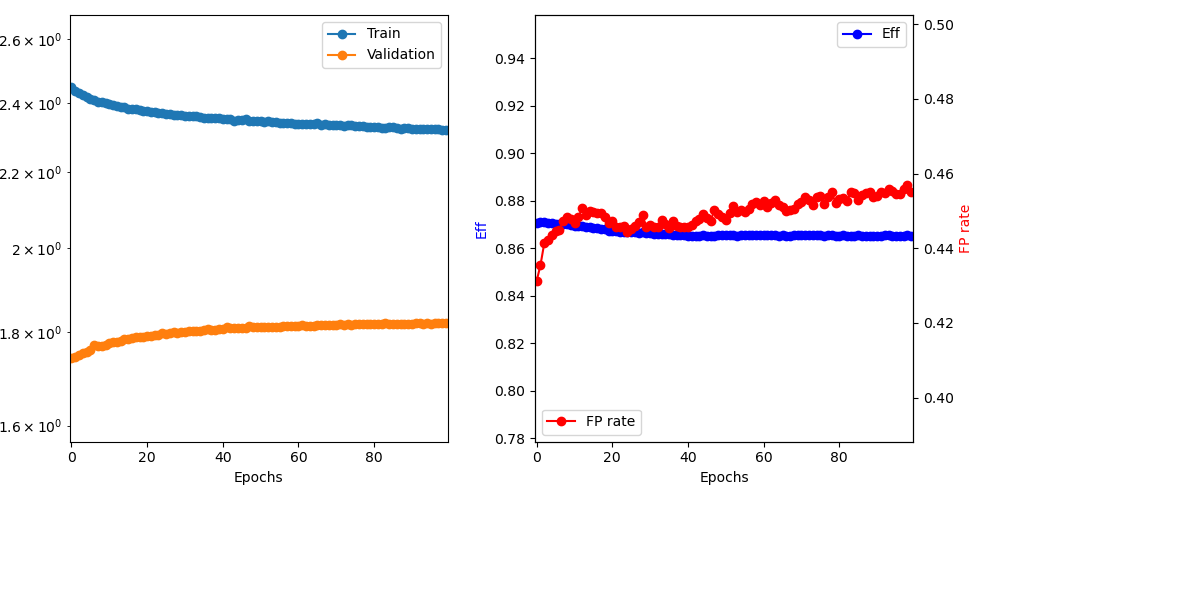

In [14]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()

In [15]:
for result in trainNet(model, optimizer, loss,
                        train_loader, val_loader,
                        n_epochs, epoch_start=len(results),
                        notebook=True):
    
    results = results.append(pd.Series(result._asdict()), ignore_index=True)
    
    xs = results.index
##    print("xs = ",xs)
    
    # Update the plot above
##    print("results.index = ",results.index,"  results.cost", results.cost)
##    print("results.index = ",results.index,"  results.val", results.val)
    lines['train'].set_data(results.index,results.cost)
    lines['val'].set_data(results.index,results.val)
    
    #filter first cost epoch (can be really large)
    max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
    min_cost = min(min(results.cost), min(results.val))
    
    # The plot limits need updating too
    
    
    
    ax.set_ylim(min_cost*.9, max_cost*1.1)  
    ax.set_xlim(-.5, len(results.cost) - .5)
    
    replace_in_ax(lax, lines['eff'], xs, results['eff_val'].apply(lambda x: x.eff_rate))
    replace_in_ax(tax, lines['fp'], xs, results['eff_val'].apply(lambda x: x.fp_rate))
    
    # Redraw the figure
    fig.canvas.draw()

    # Save each model state dictionary
    torch.save(model.state_dict(), output / f'{name}_{result.epoch}.pyt')

Number of batches: train = 5000, val = 1250


Epoch 0: train=2.44778, val=1.74218, took 202.14 s
  Validation Found 94063 of 108024, added 8626 (eff 87.08%) (0.431 FP/event)


Epoch 1: train=2.43714, val=1.7439, took 202.23 s
  Validation Found 94082 of 108024, added 8710 (eff 87.09%) (0.435 FP/event)


Epoch 2: train=2.43051, val=1.74797, took 201.45 s
  Validation Found 94098 of 108024, added 8827 (eff 87.11%) (0.441 FP/event)


Epoch 3: train=2.4236, val=1.75227, took 202.5 s
  Validation Found 94065 of 108024, added 8843 (eff 87.08%) (0.442 FP/event)


Epoch 4: train=2.41806, val=1.75558, took 200.99 s
  Validation Found 94049 of 108024, added 8869 (eff 87.06%) (0.443 FP/event)


Epoch 5: train=2.41287, val=1.75979, took 201.05 s
  Validation Found 94005 of 108024, added 8894 (eff 87.02%) (0.445 FP/event)


Epoch 6: train=2.40952, val=1.7714, took 201.15 s
  Validation Found 94001 of 108024, added 8900 (eff 87.02%) (0.445 FP/event)


Epoch 7: train=2.40457, val=1.76736, took 201.76 s
  Validation Found 94000 of 108024, added 8949 (eff 87.02%) (0.447 FP/event)


Epoch 8: train=2.40184, val=1.76912, took 200.87 s
  Validation Found 93995 of 108024, added 8967 (eff 87.01%) (0.448 FP/event)


Epoch 9: train=2.40003, val=1.77163, took 201.8 s
  Validation Found 93975 of 108024, added 8959 (eff 86.99%) (0.448 FP/event)


Epoch 10: train=2.39709, val=1.77431, took 201.51 s
  Validation Found 93927 of 108024, added 8936 (eff 86.95%) (0.447 FP/event)


Epoch 11: train=2.39305, val=1.77629, took 201.58 s
  Validation Found 93929 of 108024, added 8966 (eff 86.95%) (0.448 FP/event)


Epoch 12: train=2.39022, val=1.7784, took 201.91 s
  Validation Found 93923 of 108024, added 9014 (eff 86.95%) (0.451 FP/event)


Epoch 13: train=2.38789, val=1.78047, took 202.09 s
  Validation Found 93873 of 108024, added 8977 (eff 86.90%) (0.449 FP/event)


Epoch 14: train=2.38665, val=1.7843, took 202.22 s
  Validation Found 93866 of 108024, added 9001 (eff 86.89%) (0.45 FP/event)


Epoch 15: train=2.38294, val=1.78468, took 201.75 s
  Validation Found 93819 of 108024, added 8993 (eff 86.85%) (0.45 FP/event)


Epoch 16: train=2.38275, val=1.78619, took 202.89 s
  Validation Found 93815 of 108024, added 8991 (eff 86.85%) (0.45 FP/event)


Epoch 17: train=2.38169, val=1.78755, took 205.01 s
  Validation Found 93784 of 108024, added 8992 (eff 86.82%) (0.45 FP/event)


Epoch 18: train=2.37834, val=1.78918, took 205.21 s
  Validation Found 93754 of 108024, added 8966 (eff 86.79%) (0.448 FP/event)


Epoch 19: train=2.37651, val=1.78931, took 205.47 s
  Validation Found 93701 of 108024, added 8935 (eff 86.74%) (0.447 FP/event)


Epoch 20: train=2.37531, val=1.79152, took 205.28 s
  Validation Found 93703 of 108024, added 8949 (eff 86.74%) (0.447 FP/event)


Epoch 21: train=2.37223, val=1.79124, took 205.2 s
  Validation Found 93664 of 108024, added 8914 (eff 86.71%) (0.446 FP/event)


Epoch 22: train=2.3728, val=1.7933, took 205.24 s
  Validation Found 93655 of 108024, added 8916 (eff 86.70%) (0.446 FP/event)


Epoch 23: train=2.37094, val=1.79397, took 205.17 s
  Validation Found 93657 of 108024, added 8918 (eff 86.70%) (0.446 FP/event)


Epoch 24: train=2.36885, val=1.79742, took 205.17 s
  Validation Found 93618 of 108024, added 8888 (eff 86.66%) (0.444 FP/event)


Epoch 25: train=2.36755, val=1.79613, took 204.86 s
  Validation Found 93631 of 108024, added 8902 (eff 86.68%) (0.445 FP/event)


Epoch 26: train=2.36626, val=1.79771, took 205.19 s
  Validation Found 93634 of 108024, added 8921 (eff 86.68%) (0.446 FP/event)


Epoch 27: train=2.36282, val=1.79996, took 205.08 s
  Validation Found 93599 of 108024, added 8939 (eff 86.65%) (0.447 FP/event)


Epoch 28: train=2.36392, val=1.79858, took 205.27 s
  Validation Found 93643 of 108024, added 8976 (eff 86.69%) (0.449 FP/event)


Epoch 29: train=2.36302, val=1.79964, took 205.3 s
  Validation Found 93587 of 108024, added 8915 (eff 86.64%) (0.446 FP/event)


Epoch 30: train=2.36065, val=1.80079, took 204.9 s
  Validation Found 93579 of 108024, added 8927 (eff 86.63%) (0.446 FP/event)


Epoch 31: train=2.35997, val=1.80278, took 205.45 s
  Validation Found 93561 of 108024, added 8917 (eff 86.61%) (0.446 FP/event)


Epoch 32: train=2.36095, val=1.80147, took 205.56 s
  Validation Found 93557 of 108024, added 8914 (eff 86.61%) (0.446 FP/event)


Epoch 33: train=2.3606, val=1.80321, took 205.41 s
  Validation Found 93563 of 108024, added 8950 (eff 86.61%) (0.447 FP/event)


Epoch 34: train=2.35724, val=1.80298, took 205.88 s
  Validation Found 93557 of 108024, added 8930 (eff 86.61%) (0.446 FP/event)


Epoch 35: train=2.35637, val=1.80389, took 205.88 s
  Validation Found 93544 of 108024, added 8910 (eff 86.60%) (0.445 FP/event)


Epoch 36: train=2.35624, val=1.80644, took 205.42 s
  Validation Found 93524 of 108024, added 8949 (eff 86.58%) (0.447 FP/event)


Epoch 37: train=2.35648, val=1.80491, took 205.98 s
  Validation Found 93518 of 108024, added 8919 (eff 86.57%) (0.446 FP/event)


Epoch 38: train=2.35679, val=1.80526, took 205.57 s
  Validation Found 93523 of 108024, added 8917 (eff 86.58%) (0.446 FP/event)


Epoch 39: train=2.35442, val=1.80561, took 205.49 s
  Validation Found 93511 of 108024, added 8915 (eff 86.57%) (0.446 FP/event)


Epoch 40: train=2.35228, val=1.80631, took 205.57 s
  Validation Found 93480 of 108024, added 8914 (eff 86.54%) (0.446 FP/event)


Epoch 41: train=2.35254, val=1.81052, took 205.6 s
  Validation Found 93454 of 108024, added 8924 (eff 86.51%) (0.446 FP/event)


Epoch 42: train=2.35175, val=1.80793, took 205.61 s
  Validation Found 93450 of 108024, added 8946 (eff 86.51%) (0.447 FP/event)


Epoch 43: train=2.34743, val=1.80835, took 205.45 s
  Validation Found 93468 of 108024, added 8959 (eff 86.53%) (0.448 FP/event)


Epoch 44: train=2.35038, val=1.80847, took 205.92 s
  Validation Found 93513 of 108024, added 8983 (eff 86.57%) (0.449 FP/event)


Epoch 45: train=2.34893, val=1.80967, took 205.55 s
  Validation Found 93475 of 108024, added 8962 (eff 86.53%) (0.448 FP/event)


Epoch 46: train=2.3511, val=1.80981, took 205.52 s
  Validation Found 93476 of 108024, added 8949 (eff 86.53%) (0.447 FP/event)


Epoch 47: train=2.34689, val=1.81383, took 205.85 s
  Validation Found 93447 of 108024, added 9005 (eff 86.51%) (0.45 FP/event)


Epoch 48: train=2.34704, val=1.81106, took 206.05 s
  Validation Found 93493 of 108024, added 8985 (eff 86.55%) (0.449 FP/event)


Epoch 49: train=2.34647, val=1.81183, took 205.56 s
  Validation Found 93518 of 108024, added 8966 (eff 86.57%) (0.448 FP/event)


Epoch 50: train=2.34678, val=1.81136, took 205.62 s
  Validation Found 93485 of 108024, added 8953 (eff 86.54%) (0.448 FP/event)


Epoch 51: train=2.34361, val=1.811, took 205.74 s
  Validation Found 93500 of 108024, added 8990 (eff 86.55%) (0.449 FP/event)


Epoch 52: train=2.34624, val=1.81216, took 205.71 s
  Validation Found 93500 of 108024, added 9025 (eff 86.55%) (0.451 FP/event)


Epoch 53: train=2.3423, val=1.81152, took 205.87 s
  Validation Found 93475 of 108024, added 8994 (eff 86.53%) (0.45 FP/event)


Epoch 54: train=2.34207, val=1.81208, took 205.77 s
  Validation Found 93499 of 108024, added 9008 (eff 86.55%) (0.45 FP/event)


Epoch 55: train=2.34113, val=1.81231, took 205.12 s
  Validation Found 93481 of 108024, added 8993 (eff 86.54%) (0.45 FP/event)


Epoch 56: train=2.34041, val=1.81287, took 205.43 s
  Validation Found 93501 of 108024, added 9012 (eff 86.56%) (0.451 FP/event)


Epoch 57: train=2.3416, val=1.81281, took 205.81 s
  Validation Found 93517 of 108024, added 9040 (eff 86.57%) (0.452 FP/event)


Epoch 58: train=2.34054, val=1.81368, took 205.54 s
  Validation Found 93497 of 108024, added 9049 (eff 86.55%) (0.452 FP/event)


Epoch 59: train=2.33809, val=1.8134, took 205.76 s
  Validation Found 93519 of 108024, added 9031 (eff 86.57%) (0.452 FP/event)


Epoch 60: train=2.33903, val=1.81351, took 205.3 s
  Validation Found 93520 of 108024, added 9053 (eff 86.57%) (0.453 FP/event)


Epoch 61: train=2.33628, val=1.81545, took 205.6 s
  Validation Found 93494 of 108024, added 9022 (eff 86.55%) (0.451 FP/event)


Epoch 62: train=2.33887, val=1.81433, took 205.29 s
  Validation Found 93519 of 108024, added 9045 (eff 86.57%) (0.452 FP/event)


Epoch 63: train=2.33731, val=1.81427, took 204.11 s
  Validation Found 93503 of 108024, added 9061 (eff 86.56%) (0.453 FP/event)


Epoch 64: train=2.33809, val=1.81423, took 204.59 s
  Validation Found 93473 of 108024, added 9031 (eff 86.53%) (0.452 FP/event)


Epoch 65: train=2.33918, val=1.81555, took 205.04 s
  Validation Found 93486 of 108024, added 9022 (eff 86.54%) (0.451 FP/event)


Epoch 66: train=2.33415, val=1.81494, took 204.73 s
  Validation Found 93471 of 108024, added 9002 (eff 86.53%) (0.45 FP/event)


Epoch 67: train=2.33718, val=1.81508, took 204.2 s
  Validation Found 93478 of 108024, added 9004 (eff 86.53%) (0.45 FP/event)


Epoch 68: train=2.3335, val=1.81491, took 205.0 s
  Validation Found 93492 of 108024, added 9012 (eff 86.55%) (0.451 FP/event)


Epoch 69: train=2.33353, val=1.81586, took 205.04 s
  Validation Found 93504 of 108024, added 9036 (eff 86.56%) (0.452 FP/event)


Epoch 70: train=2.3337, val=1.81569, took 204.83 s
  Validation Found 93485 of 108024, added 9046 (eff 86.54%) (0.452 FP/event)


Epoch 71: train=2.33439, val=1.81721, took 204.85 s
  Validation Found 93505 of 108024, added 9076 (eff 86.56%) (0.454 FP/event)


Epoch 72: train=2.33283, val=1.81614, took 205.21 s
  Validation Found 93520 of 108024, added 9057 (eff 86.57%) (0.453 FP/event)


Epoch 73: train=2.33322, val=1.81768, took 204.7 s
  Validation Found 93505 of 108024, added 9033 (eff 86.56%) (0.452 FP/event)


Epoch 74: train=2.33345, val=1.81667, took 204.91 s
  Validation Found 93512 of 108024, added 9074 (eff 86.57%) (0.454 FP/event)


Epoch 75: train=2.33217, val=1.81714, took 205.39 s
  Validation Found 93487 of 108024, added 9081 (eff 86.54%) (0.454 FP/event)


Epoch 76: train=2.33087, val=1.81689, took 204.93 s
  Validation Found 93473 of 108024, added 9037 (eff 86.53%) (0.452 FP/event)


Epoch 77: train=2.33179, val=1.8172, took 204.81 s
  Validation Found 93522 of 108024, added 9075 (eff 86.58%) (0.454 FP/event)


Epoch 78: train=2.32907, val=1.81814, took 205.01 s
  Validation Found 93506 of 108024, added 9102 (eff 86.56%) (0.455 FP/event)


Epoch 79: train=2.32796, val=1.81791, took 204.88 s
  Validation Found 93455 of 108024, added 9043 (eff 86.51%) (0.452 FP/event)


Epoch 80: train=2.32888, val=1.81774, took 204.72 s
  Validation Found 93449 of 108024, added 9062 (eff 86.51%) (0.453 FP/event)


Epoch 81: train=2.32881, val=1.81896, took 204.73 s
  Validation Found 93496 of 108024, added 9068 (eff 86.55%) (0.453 FP/event)


Epoch 82: train=2.32718, val=1.81729, took 205.02 s
  Validation Found 93475 of 108024, added 9055 (eff 86.53%) (0.453 FP/event)


Epoch 83: train=2.32713, val=1.81959, took 204.95 s
  Validation Found 93471 of 108024, added 9100 (eff 86.53%) (0.455 FP/event)


Epoch 84: train=2.32953, val=1.81804, took 204.72 s
  Validation Found 93463 of 108024, added 9099 (eff 86.52%) (0.455 FP/event)


Epoch 85: train=2.32739, val=1.81838, took 204.81 s
  Validation Found 93484 of 108024, added 9061 (eff 86.54%) (0.453 FP/event)


Epoch 86: train=2.32716, val=1.81857, took 205.21 s
  Validation Found 93477 of 108024, added 9086 (eff 86.53%) (0.454 FP/event)


Epoch 87: train=2.32179, val=1.8188, took 204.59 s
  Validation Found 93465 of 108024, added 9096 (eff 86.52%) (0.455 FP/event)


Epoch 88: train=2.32525, val=1.81825, took 204.72 s
  Validation Found 93459 of 108024, added 9103 (eff 86.52%) (0.455 FP/event)


Epoch 89: train=2.32647, val=1.81877, took 204.93 s
  Validation Found 93464 of 108024, added 9076 (eff 86.52%) (0.454 FP/event)


Epoch 90: train=2.32412, val=1.8186, took 204.98 s
  Validation Found 93468 of 108024, added 9081 (eff 86.53%) (0.454 FP/event)


Epoch 91: train=2.32311, val=1.81979, took 204.86 s
  Validation Found 93454 of 108024, added 9102 (eff 86.51%) (0.455 FP/event)


Epoch 92: train=2.3238, val=1.81933, took 204.92 s
  Validation Found 93488 of 108024, added 9096 (eff 86.54%) (0.455 FP/event)


Epoch 93: train=2.32405, val=1.81867, took 204.46 s
  Validation Found 93493 of 108024, added 9118 (eff 86.55%) (0.456 FP/event)


Epoch 94: train=2.32363, val=1.81944, took 204.79 s
  Validation Found 93476 of 108024, added 9106 (eff 86.53%) (0.455 FP/event)


Epoch 95: train=2.3224, val=1.81911, took 204.75 s
  Validation Found 93456 of 108024, added 9089 (eff 86.51%) (0.454 FP/event)


Epoch 96: train=2.32381, val=1.81947, took 204.66 s
  Validation Found 93447 of 108024, added 9091 (eff 86.51%) (0.455 FP/event)


Epoch 97: train=2.32198, val=1.82074, took 204.39 s
  Validation Found 93460 of 108024, added 9117 (eff 86.52%) (0.456 FP/event)


Epoch 98: train=2.31928, val=1.82064, took 205.04 s
  Validation Found 93485 of 108024, added 9137 (eff 86.54%) (0.457 FP/event)


Epoch 99: train=2.32055, val=1.8196, took 204.44 s
  Validation Found 93457 of 108024, added 9103 (eff 86.52%) (0.455 FP/event)



In [16]:
torch.save(model.state_dict(), output / f'{name}_final.pyt')

In [17]:
results.to_hdf(f'{name}_stats.hdf5', 'results')

/apps/miniconda3/envs/june2020-gpu/lib/python3.7/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block1_values] [items->Index(['epoch', 'eff_val'], dtype='object')]

  encoding=encoding,


<IPython.core.display.Javascript object>


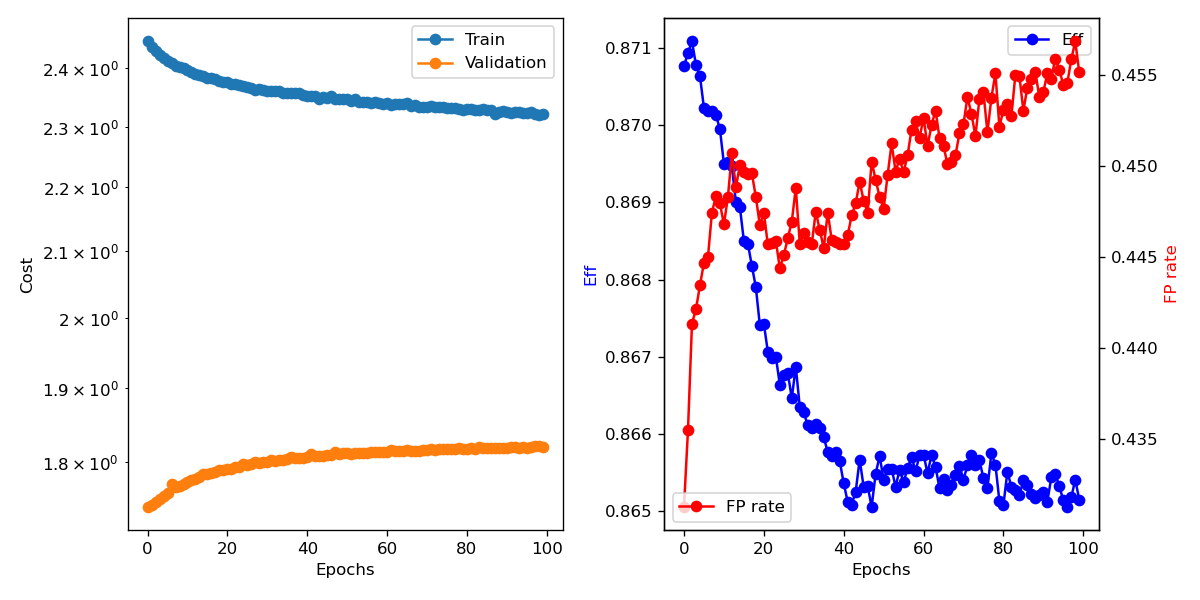

In [20]:
dual_train_plots(results.index,
                 results.cost, results.val, 
                 results['eff_val'].apply(lambda x: x.eff_rate),
                 results['eff_val'].apply(lambda x: x.fp_rate))
plt.tight_layout()
plt.savefig(str(output / f'{name}_stats_a.png'))

Go ahead and save the final model (even though it was also saved above):

Save the output results:

In [21]:
##torch.cuda.empty_cache()"
quit()

